In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import seaborn as sns
from tqdm import tqdm
import astropy.units as u
from astropy.constants import h, c, eps0, a0
from collections.abc import Sequence

#from light_old import GaussianBeam
from lightmatter import GaussianBeam, Lattice1d, BowtieLattice2d, LaserSetup

sns.set_style('whitegrid')

In [2]:
lat1 = Lattice1d(
    lattice_direction_vec=(1,0,0),
    intersect_angle=0,
    pol_Jones_vec=(1,0),
    lambda_=1064,
    w0=700,
    P=11,
    z0=0,
)

lat2 = Lattice1d(
    lattice_direction_vec=(1,0,0),
    intersect_angle=45,
    pol_Jones_vec=(1,0),
    lambda_=1064,
    w0=700,
    P=11,
    z0=0,
)

lat3 = Lattice1d(
    lattice_direction_vec=(1,0,0),
    intersect_angle=90,
    pol_Jones_vec=(1,0),
    lambda_=1064,
    w0=700,
    P=11,
    z0=0,
)

In [3]:
n = 101

x = np.linspace(-1, 1, n) * u.um
y = np.linspace(-1000, 1000, n) * u.um
z = np.linspace(-1000, 1000, n) * u.um

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

I1 = lat1.I(X, Y, Z)
I2 = lat2.I(X, Y, Z)
I3 = lat3.I(X, Y, Z)

/home/lelo/anaconda3/envs/lightmatter/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


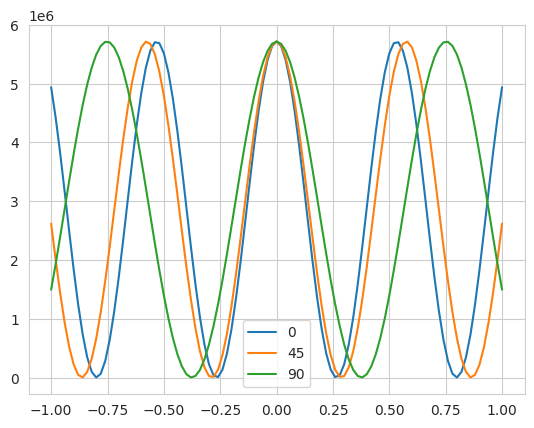

In [4]:
plt.plot(x.value, I1.value[:, n//2, n//2], label='0')
plt.plot(x.value, I2.value[:, n//2, n//2], label='45')
plt.plot(x.value, I3.value[:, n//2, n//2], label='90')
plt.legend()

In [5]:
bowtie = BowtieLattice2d(
    lattice_direction_vec1=(1,0,0),
    lattice_direction_vec2=(0,1,0),
    pol_Jones_vec=(0,1),
    lambda_=1064,
    w0=700,
    P=11,
    z0=0,
)

In [6]:
n = 101

x = np.linspace(-1, 1, n) * u.um
y = np.linspace(-1, 1, n) * u.um
z = np.linspace(-1000, 1000, n) * u.um

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

I4 = bowtie.I(X, Y, Z).to(u.mW/u.cm**2)

In [7]:
lat1d_x = Lattice1d(
    lattice_direction_vec=(1,0,0),
    intersect_angle=0,
    pol_Jones_vec=(0,1),
    lambda_=1064,
    w0=700,
    P=11,
    z0=0,
)

lat1d_y = Lattice1d(
    lattice_direction_vec=(0,1,0),
    intersect_angle=0,
    pol_Jones_vec=(0,1),
    lambda_=1064,
    w0=700,
    P=11,
    z0=0,
)

lasers = [lat1d_x, lat1d_y]

lat2d = LaserSetup(lasers)

In [8]:
I5 = lat2d.I(X, Y, Z).to(u.mW/u.cm**2)

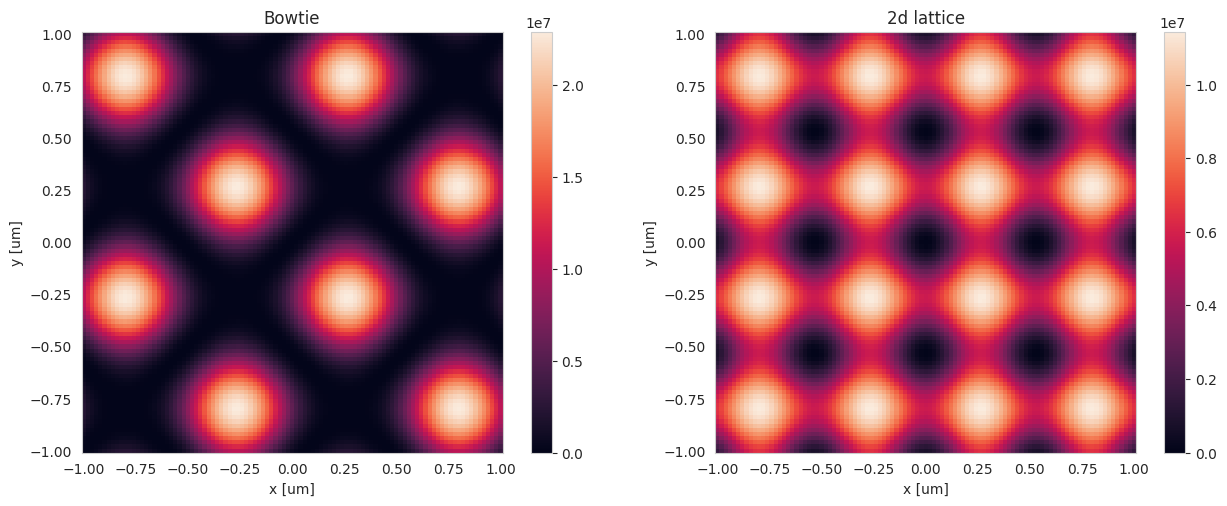

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

cb1 = axs[0].pcolormesh(x.value, y.value, I4[:,:,n//2].value)
axs[0].set_title('Bowtie')
axs[0].set_xlabel('x [um]')
axs[0].set_ylabel('y [um]')
axs[0].set_aspect('equal')

cb2 = axs[1].pcolormesh(x.value, y.value, I5[:,:,n//2].value)
axs[1].set_title('2d lattice')
axs[1].set_xlabel('x [um]')
axs[1].set_ylabel('y [um]')
axs[1].set_aspect('equal')

fig.colorbar(cb1)
fig.colorbar(cb2)
fig.tight_layout()

In [10]:
np.max(I4)

<Quantity 22863093.98938971 mW / cm2>

In [11]:
np.max(I5)

<Quantity 11431546.99469486 mW / cm2>

In [12]:
from astropy.constants import eps0, a0, h, hbar

alpha = (599.17 * 4*np.pi*eps0*a0**3 / h).to(u.Hz/(u.V/u.m)**2)
alpha

<Quantity 1.49092578e-05 m2 Hz / V2>

In [13]:
V_bowtie = - (1/(2*eps0*c) * alpha * I4).to(u.kHz)
V_lat2d = - (1/(2*eps0*c) * alpha * I5).to(u.kHz)

In [14]:
assert bowtie.k == lat2d.lasers[0].k, "We want same wavelength for regular and bowtie lattice"

m_K40 = 39.96399848 * u.u

Er = (hbar**2 * bowtie.k**2 / (2*m_K40) / h).to(u.kHz)
Er

<Quantity 4.40985944 kHz>

In [15]:
np.min(V_bowtie / Er)

<Quantity -145.60183569>

In [16]:
np.min(V_lat2d / Er)

<Quantity -72.80091785>

In [17]:
beam1 = GaussianBeam(
    beam_direction_vec=(1,0,0),
    pol_Jones_vec=(1,0),
    lambda_=1064,
    w0=(350, 175),
    P=11,
    z0=0,
)

beam2 = GaussianBeam(
    beam_direction_vec=(-1,0,0),
    pol_Jones_vec=(1,0),
    lambda_=1064,
    w0=(350, 175),
    P=11,
    z0=0,
)

In [18]:
n = 101

x = np.linspace(-1, 1, n) * u.um
y = np.linspace(-1000, 1000, n) * u.um
z = np.linspace(-1000, 1000, n) * u.um

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

In [19]:
Evec1 = beam1.E_vec(X, Y, Z)
Evec2 = beam2.E_vec(X, Y, Z)

In [20]:
L = Evec1 + Evec2
L = L[0]*np.conjugate(L[0]) + L[1]*np.conjugate(L[1]) + L[2]*np.conjugate(L[2])
L.shape

(101, 101, 101)

/home/lelo/anaconda3/envs/lightmatter/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/lelo/anaconda3/envs/lightmatter/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


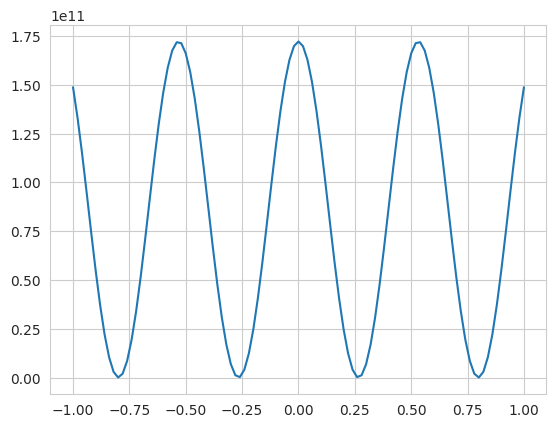

In [21]:
plt.plot(x.value, L[:, n//2, n//2].value)

In [22]:
beam = GaussianBeam(
    beam_direction_vec=(1,0,0),
    pol_Jones_vec=(1,0),
    lambda_=1064,
    w0=700,
    P=11,
    z0=0,
)

In [23]:
n = 101

x = np.linspace(-1000, 1000, n) * u.mm
y = np.linspace(-1000, 1000, n) * u.um
z = np.linspace(-1000, 1000, n) * u.um

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

I = beam.I(X, Y, Z).value

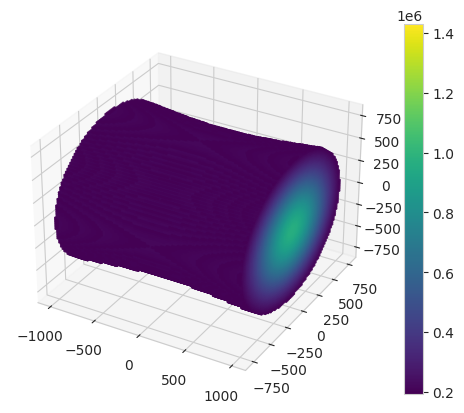

In [24]:
mask = I > beam.I0.value/np.exp(2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[mask], Y[mask], Z[mask], c=I[mask], cmap='viridis', s=1)

fig.colorbar(ax.scatter(X[mask], Y[mask], Z[mask], c=I[mask], cmap='viridis', s=1))